In [1]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import monounet.MonogenicNets
from pprint import pprint

MONO_ARCH_NAMES = monounet.MonogenicNets.__all__

In [2]:
# model_name = "UNext"
# model_name = "UNextDA"
# model_name = "CMUNeXt-S"
# model_name = "CMUNeXt-SDA"
# model_name = "TinyUNet"
# model_name = "TinyUNetDA"
# model_name = "XTinyUNetDA"
# model_name = "XTinyMonoUNetScale1"
# model_name = "XTinyMonoUNetScale6"
# model_name = "XTinyMonoUNetScale1_no_ortho"
# model_name = "XTinyMonoUNetScale6_no_ortho"
# model_name = "XTinyMonoV2UNetScale1"
# model_name = "XTinyMonoV2UNetScale6"
# model_name = "XTinyMonoV2GatedUNet"
# model_name = "XTinyMonoV2GatedEncUNetV1"
model_name = "XTinyMonoV2GatedEncUNetV1DA"
# model_name = "XTinyUNetB"
# model_name = "XTinyUNetBDA"
# model_name = "XTinyMonoV2GatedEncUNetV1BDA"
# model_name = "XTinyUNetL"
# model_name = "XTinyMonoV2GatedEncUNetV1LDA"
# model_name = "XTinyMonoV2GatedEncUNet"
# model_name = "XTinyMonoV2GatedEncUNetV0"
# model_name = "XTinyMonoV2GatedEncDecUNet"
# model_name = "XTinyMonoUNetgated"
# model_name = "XTinyMonoUNetgatedenc"
# model_name = "XTinyMonoUNetgateddec"
# model_name = "XTinyMonoUNetgatedencdec"

# train_dataset = "Dataset072_GE_LQP9"
train_dataset = "Dataset073_GE_LE"
# train_dataset = "Dataset070_Clarius_L15"
model_dir = f"models/{model_name}/{train_dataset}"
fold = 0

ckpt = f"{model_dir}/fold_{fold}/model_best.pth"
if model_name.endswith("DA"):
    model_name = model_name.replace("DA", "")
model = monounet.MonogenicNets.__dict__[model_name](in_channels=1,
                                                num_classes=1,
                                                img_size=(256, 256),
                                                deep_supervision=False)

ckpt_data = torch.load(ckpt)
model.load_state_dict(ckpt_data)

model.eval()
# model.mono2d.get_params()
pprint(model.encoder.mono2d.get_params())
for name, param in model.named_parameters():
    # if "mono2d" in name:
    if "gate" in name:
        print(name, param.shape)
        print(param)


{'T': 0.0,
 'cut_off': 0.5,
 'episilon': 0.0001,
 'g': 10,
 'in_channels': 1,
 'max_wl': 128.0,
 'min_wl': 3.0,
 'norm': 'std',
 'nscale': 8,
 'return_phase': True,
 'sigmaonf': [[0.3670284152030945,
               0.6149424910545349,
               0.699813723564148,
               0.31561776995658875,
               0.22999133169651031,
               0.39822620153427124,
               0.348957896232605,
               0.4533810615539551]],
 'trainable': True,
 'wls': [[57.14607238769531,
          20.601959228515625,
          31.178678512573242,
          7.849029064178467,
          100.60354614257812,
          82.28846740722656,
          30.562335968017578,
          88.1963882446289]]}
encoder.gate_weights.0 torch.Size([1])
Parameter containing:
tensor([0.9800], requires_grad=True)
encoder.gate_weights.1 torch.Size([2])
Parameter containing:
tensor([0.2088, 0.4497], requires_grad=True)
encoder.gate_weights.2 torch.Size([2])
Parameter containing:
tensor([-0.0539,  0.0855], req

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Blocks (your versions)
# -----------------------------

class DoubleConv(nn.Module):
    """
    Basic UNet block: Conv -> ReLU -> Conv -> ReLU
    in_ch -> out_ch (both convs use out_ch as channels)
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch, affine=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch, affine=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    """
    Residual version of DoubleConv:
    x -> Conv(out_ch) -> ReLU -> Conv(out_ch) -> BN
    y = F(x) + skip(x), then ReLU

    If in_ch != out_ch, use 1x1 conv as projection.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch, affine=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch, affine=False)
        self.relu  = nn.ReLU(inplace=True)

        if in_ch != out_ch:
            self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        else:
            self.proj = None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.proj is not None:
            identity = self.proj(identity)

        out = out + identity
        out = self.relu(out)
        return out

# -----------------------------
# Flexible UNet base
# -----------------------------

class UNetBase(nn.Module):
    """
    2D U-Net with configurable:
      - features_per_stage: list of channels per encoder stage
      - blocks_per_stage: list of #blocks per encoder stage (each block_cls has 2 convs inside)

    Decoder mirrors encoder (#stages-1) and uses same #blocks per stage (reversed, excluding bottleneck).
    """
    def __init__(
        self,
        in_ch=1,
        out_ch=1,
        features_per_stage=None,    # e.g. [64, 128, 256, 512, 1024]
        blocks_per_stage=None,      # e.g. [2, 2, 2, 2, 2]
        block_cls=DoubleConv,
    ):
        super().__init__()

        if features_per_stage is None:
            features_per_stage = [64, 128, 256, 512, 1024]
        if blocks_per_stage is None:
            blocks_per_stage = [2] * len(features_per_stage)
        assert len(features_per_stage) == len(blocks_per_stage), "Length mismatch"

        self.features_per_stage = features_per_stage
        self.blocks_per_stage   = blocks_per_stage
        self.n_stages = len(features_per_stage)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # ----- Encoder -----
        self.enc_stages = nn.ModuleList()
        prev_ch = in_ch
        for stage_idx, (out_ch_stage, n_blocks) in enumerate(zip(features_per_stage, blocks_per_stage)):
            blocks = []
            in_ch_block = prev_ch
            for b in range(n_blocks):
                blocks.append(block_cls(in_ch_block, out_ch_stage))
                in_ch_block = out_ch_stage
            stage = nn.Sequential(*blocks)
            self._tag_convs(stage, kind="enc", stage_idx=stage_idx)
            self.enc_stages.append(stage)
            prev_ch = out_ch_stage

        # ----- Decoder -----
        # decoder has n_stages-1 stages
        self.upconvs = nn.ModuleList()
        self.dec_stages = nn.ModuleList()

        # use same blocks_per_stage mirrored (excluding bottleneck)
        dec_blocks_per_stage = list(blocks_per_stage[:-1])[::-1]

        for dec_idx, (enc_idx_above, n_blocks) in enumerate(
            zip(range(self.n_stages - 1, 0, -1), dec_blocks_per_stage)
        ):
            in_ch_up = features_per_stage[enc_idx_above]
            out_ch_up = features_per_stage[enc_idx_above - 1]
            up = nn.ConvTranspose2d(in_ch_up, out_ch_up, kernel_size=2, stride=2)
            # tag upconv as part of this decoder stage
            up._stage_kind = "dec"
            up._stage_idx  = dec_idx
            self.upconvs.append(up)

            # after concat: out_ch_up (skip) + out_ch_up (up) = 2*out_ch_up
            blocks = []
            in_ch_block = 2 * out_ch_up
            for b in range(n_blocks):
                blocks.append(block_cls(in_ch_block, out_ch_up))
                in_ch_block = out_ch_up
            stage = nn.Sequential(*blocks)
            self._tag_convs(stage, kind="dec", stage_idx=dec_idx)
            self.dec_stages.append(stage)

        # Final conv (treat as its own tiny "head" stage if you want)
        self.final_conv = nn.Conv2d(features_per_stage[0], out_ch, kernel_size=1)
        self.final_conv._stage_kind = "head"
        self.final_conv._stage_idx = 0

    @staticmethod
    def _tag_convs(stage_module, kind, stage_idx):
        """
        Tag all Conv2d / ConvTranspose2d inside this stage
        so we can attribute params+FLOPs later.
        """
        for m in stage_module.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                m._stage_kind = kind
                m._stage_idx  = stage_idx

    def forward(self, x):
        enc_feats = []

        # Encoder
        print("Encoder")
        for i, stage in enumerate(self.enc_stages):
            print("x", x.shape)
            x = stage(x)
            enc_feats.append(x)
            if i < self.n_stages - 1:
                x = self.pool(x)

        # Decoder
        x = enc_feats[-1]
        print("Decoder")
        for dec_idx, (up, dec_stage) in enumerate(zip(self.upconvs, self.dec_stages)):
            print("x", x.shape)
            x = up(x)
            skip = enc_feats[self.n_stages - 2 - dec_idx]  # mirror
            # no cropping here; assume 2^n input size
            x = torch.cat([skip, x], dim=1)
            x = dec_stage(x)

        x = self.final_conv(x)
        return x

class UNetBasic(UNetBase):
    def __init__(self, in_ch=1, out_ch=1, features_per_stage=None, blocks_per_stage=None):
        super().__init__(
            in_ch=in_ch,
            out_ch=out_ch,
            features_per_stage=features_per_stage,
            blocks_per_stage=blocks_per_stage,
            block_cls=DoubleConv,
        )

class UNetResidual(UNetBase):
    def __init__(self, in_ch=1, out_ch=1, features_per_stage=None, blocks_per_stage=None):
        super().__init__(
            in_ch=in_ch,
            out_ch=out_ch,
            features_per_stage=features_per_stage,
            blocks_per_stage=blocks_per_stage,
            block_cls=ResidualBlock,
        )

# -----------------------------
# Per-stage param + FLOP stats
# -----------------------------

def conv_flops(module, x, y):
    """
    Rough FLOPs for Conv2d / ConvTranspose2d: MACs * 2
    x, y are tensors (input, output)
    """
    # x: (N, Cin, H_in, W_in), y: (N, Cout, H_out, W_out)
    Cin = module.in_channels
    Cout = module.out_channels
    kh, kw = module.kernel_size
    groups = module.groups if hasattr(module, "groups") else 1
    N, _, H_out, W_out = y.shape
    # per-output-pixel MACs: (Cin/groups) * kh * kw
    macs_per_out = (Cin // groups) * kh * kw
    total_macs = N * H_out * W_out * Cout * macs_per_out
    return 2 * total_macs  # multiply-add

def profile_stages(model, input_shape=(1, 1, 256, 256)):
    """
    Run a dummy forward and collect per-stage (encoder/decoder/head) params + FLOPs.
    """
    device = next(model.parameters()).device
    x = torch.randn(*input_shape, device=device)

    stage_stats = defaultdict(lambda: {"params": 0, "flops": 0})
    hooks = []

    def hook_fn(module, inp, out):
        kind = getattr(module, "_stage_kind", None)
        idx  = getattr(module, "_stage_idx", None)
        if kind is None or idx is None:
            return
        key = (kind, idx)
        # params for this conv
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        stage_stats[key]["params"] += params
        # flops
        fl = conv_flops(module, inp[0], out)
        stage_stats[key]["flops"] += fl

    # register hooks on all convs with stage tags
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) and hasattr(m, "_stage_kind"):
            hooks.append(m.register_forward_hook(hook_fn))

    # forward pass
    model.eval()
    with torch.no_grad():
        _ = model(x)

    # remove hooks
    for h in hooks:
        h.remove()

    return stage_stats

def plot_stage_stats(stats, title="UNet Stage Params & FLOPs"):
    """
    stats: dict from profile_stages()
           keys = (kind, idx)
           values = { "params": int, "flops": int }
    """

    # ---- FORCE U-Net ordering ----
    encoder_keys = sorted([k for k in stats.keys() if k[0] == "enc"], key=lambda x: x[1])
    decoder_keys = sorted([k for k in stats.keys() if k[0] == "dec"], key=lambda x: x[1])
    head_keys    = sorted([k for k in stats.keys() if k[0] == "head"], key=lambda x: x[1])

    ordered_keys = encoder_keys + decoder_keys + head_keys

    labels = [f"{k[0]}{k[1]}" for k in ordered_keys]
    params = [stats[k]["params"] for k in ordered_keys]
    flops  = [stats[k]["flops"]  for k in ordered_keys]

    x = np.arange(len(labels))

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # ---------------------------
    # Params (left axis)
    # ---------------------------
    bar1 = ax1.bar(
        x - 0.2, params, width=0.4,
        label="Params", color="tab:blue"
    )
    ax1.set_ylabel("Parameters", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # ---------------------------
    # FLOPs (right axis)
    # ---------------------------
    ax2 = ax1.twinx()
    bar2 = ax2.bar(
        x + 0.2, flops, width=0.4,
        label="FLOPs", color="tab:red", alpha=0.7
    )
    ax2.set_ylabel("FLOPs", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # ---------------------------
    # X-axis and title
    # ---------------------------
    plt.xticks(x, labels)
    plt.title(title)

    # Merge legends
    bars = [bar1, bar2]
    plt.legend(bars, [f"Params {sum(params):,}", f"FLOPs {sum(flops):,}"], loc="upper right")

    plt.tight_layout()
    plt.show()

    return params, flops


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Encoder
x torch.Size([1, 1, 256, 256])
x torch.Size([1, 1, 128, 128])
x torch.Size([1, 2, 64, 64])
x torch.Size([1, 4, 32, 32])
x torch.Size([1, 8, 16, 16])
x torch.Size([1, 8, 8, 8])
x torch.Size([1, 8, 4, 4])
Decoder
x torch.Size([1, 8, 4, 4])
x torch.Size([1, 8, 8, 8])
x torch.Size([1, 8, 16, 16])
x torch.Size([1, 8, 32, 32])
x torch.Size([1, 4, 64, 64])
x torch.Size([1, 2, 128, 128])


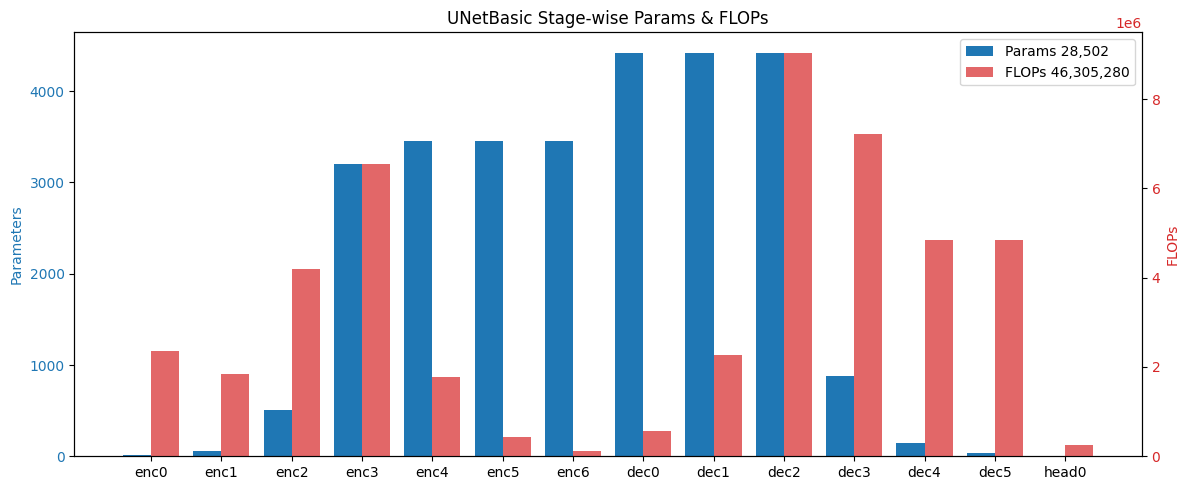

params: 28,502
params: 28,502
flops: 46,305,280


In [ ]:
# features = [64, 128, 256, 512, 1024]
# blocks   = [2, 2, 2, 2, 2]

# features = [1, 2, 4, 8, 8, 8, 8]
# blocks   = [1, 1, 2, 3, 3, 3, 3]

# features = [1, 2, 4, 8, 4, 2, 1]
# blocks   = [2, 2, 3, 3, 3, 2, 2]



model = UNetResidual(in_ch=1, out_ch=2, features_per_stage=features, blocks_per_stage=blocks)


stats = profile_stages(model, input_shape=(1, 1, 256, 256))
params, flops = plot_stage_stats(stats, title="UNetBasic Stage-wise Params & FLOPs")

print(f"params: {count_params(model):,}")
print(f"params: {sum(params):,}")
print(f"flops: {sum(flops):,}")

In [81]:
model

UNetResidual(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_stages): ModuleList(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=False, trac